# Run Theta Model
Steps:
1. Read dataset file
2. Create training & test data
3. Build LSTM model
4. Forecast Theta lines

In [73]:
# Import file and data libraries
import math
import pickle
import numpy as np
import pandas as pd 
import collections
import matplotlib.pyplot as plt
from pprint import pprint

# Import LSTM layers form the Keras library
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

# Import Matthews Correlation Coefficient module (MCC)
from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

# Step 1. Read dataset file

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# Read X & Y datasets from Pickle file, along with the metadata
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Code/3. Compare/Dataset/"

with open(dataset_path + "Dataset Theta.pickle", "rb") as f:
    X = pickle.load(f)
    Y = pickle.load(f)  # Contains Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm
    Metadata = pickle.load(f) # Contains the Company ID, ticker, sector and Dataset ID
f.close()

In [76]:
# Check number of datasets
print(len(X), len(Y), len(Metadata))

3989 3989 3989


In [77]:
# Check Theta Lines (the last 2 rows are NaN because Theta uses 2 level differentiation)
X[0]
# The coefficients for each Theta line:
# Theta 1: 0.25, Theta 2 = 0.5, Theta 3 = 0.75
# Theta 4: 1.25, Theta 5 = 1.5, Theta 6 = 2

Date    HL_Avg     Volume  HL_Avg_Norm  Volume_Norm    Theta1  \
1824 1988-03-02  0.395089  292320000     0.001910     0.039388  0.001947   
1825 1988-03-03  0.408482  473760000     0.001984     0.063835  0.001970   
1826 1988-03-04  0.412946  209440000     0.002009     0.028220  0.002064   
1827 1988-03-07  0.420759  207200000     0.002052     0.027918  0.002020   
1828 1988-03-08  0.415179  144480000     0.002021     0.019467  0.002049   
...         ...       ...        ...          ...          ...       ...   
3083 1993-02-23  0.487723  194073600     0.002422     0.026150  0.002325   
3084 1993-02-24  0.473214  286563200     0.002342     0.038612  0.002407   
3085 1993-02-25  0.482143  167227200     0.002391     0.022532  0.002368   
3086 1993-02-26  0.475446  294884800     0.002354     0.039733       NaN   
3087 1993-03-01  0.474330  119302400     0.002348     0.016075       NaN   

        Theta2    Theta3    Theta4    Theta5    Theta6  
1824  0.001935  0.001923  0.001898  0.001886  0.001861  
1825  0.001975  0.001980  0.001989  0.001993  0.002003  
1826  0.002046  0.002027  0.001990  0.001972  0.001935  
1827  0.002030  0.002041  0.002063  0.002074  0.002095  
1828  0.002040  0.002030  0.002012  0.002003  0.001984  
...        ...       ...       ...       ...       ...  
3083  0.002357  0.002390  0.002454  0.002487  0.002552  
3084  0.002385  0.002363  0.002320  0.002299  0.002256  
3085  0.002376  0.002383  0.002399  0.002407  0.002422  
3086       NaN       NaN       NaN       NaN       NaN  
3087       NaN       NaN       NaN       NaN       NaN  

[1264 rows x 11 columns]

In [78]:
# Check that the Y dataset has the normalised HL Avg and normalised X Last Price
Y[0] # Contains Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm

array([0.48337050000000004, 0.4743305, 1.9058441318869541, 'U1', 65, 5,
       0.0023979612733380485, 0.0023480111716386197, 'U1'], dtype=object)

# Step 2. Create training & test data

In [79]:
# The training data for LSTM model uses:
# X: normalised price + normalised volume
# Y: normalised price 3 months later

# The test/forecast data for LSTM model uses:
# X: normalised Theta lines + normalised volume
# Output: normalised Theta1 to Theta6 3 months later (average them to get the forecasted price)

In [80]:
# Use the last 200 days first (originally 1230 days)
# For training use 100 datasets first (originally [1000:3989])
X_Train_DF  = [X[i][-1230:-2]["HL_Avg_Norm"] for i in range(1000,3989)] 

# For forecasting Theta lines use 1000 datasets (only the first 10000 has Theta lines)
# Don't use the last 2 rows because they are NaN (because Theta differentiate & integrate to level 2)
X_Test_DF   = [X[i][-1230:-2]["HL_Avg_Norm"] for i in range(1000)]
X_Theta3_DF = [X[i][-1230:-2]["Theta3"] for i in range(1000)]
X_Theta4_DF = [X[i][-1230:-2]["Theta4"] for i in range(1000)]

# Convert to Numpy array 
X_Train  = np.array([np.array(X_Train_DF[i])  for i in range(len(X_Train_DF))])
X_Test   = np.array([np.array(X_Test_DF[i])   for i in range(len(X_Test_DF))])
X_Theta3 = np.array([np.array(X_Theta3_DF[i]) for i in range(len(X_Theta3_DF))])
X_Theta4 = np.array([np.array(X_Theta4_DF[i]) for i in range(len(X_Theta4_DF))])

# LSTM output is numeric, so take the Y Avg Norm (Y[i][6])
Y_Train = np.array([Y[i][6] for i in range(1000,3989)])
Y_Test  = np.array([Y[i][6] for i in range(1000)])
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, X_Theta3.shape, X_Theta4.shape, Y_Test.shape)

(2989, 1228) (2989,)
(1000, 1228) (1000, 1228) (1000, 1228) (1000,)


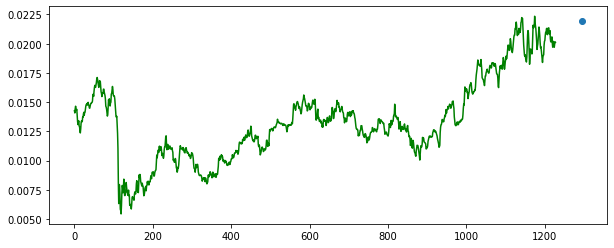

In [81]:
plt.figure(figsize=(10, 4))
plt.plot(X_Train[0], color="green")
plt.plot(1294, Y_Train[0], marker="o")
plt.show()

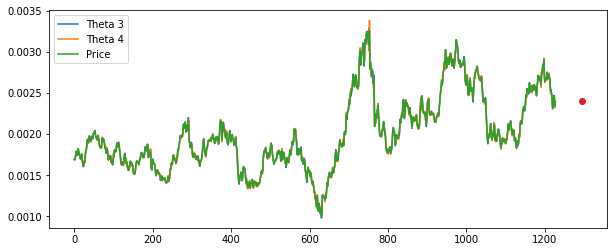

In [82]:
plt.figure(figsize=(10, 4))
plt.plot(X_Theta3[0], label = "Theta 3") #, color="green"
plt.plot(X_Theta4[0], label = "Theta 4") #, color="blue"
plt.plot(X_Test[0], label = "Price") #, color="black"
plt.plot(1294, Y_Test[0], marker="o") #, color="red"
plt.legend(loc="upper left")
plt.show()

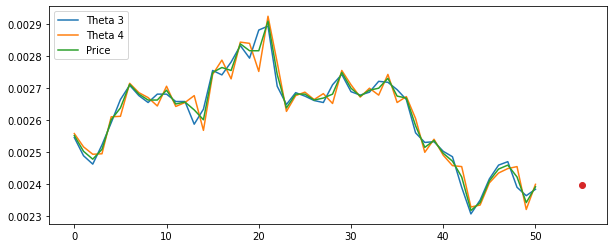

In [83]:
plt.figure(figsize=(10, 4))
plt.plot(X_Theta3[0][-51:], label = "Theta 3") #, color="green"
plt.plot(X_Theta4[0][-51:], label = "Theta 4") #, color="blue"
plt.plot(X_Test[0][-51:], label = "Price") #, color="black"
plt.plot(55, Y_Test[0], marker="o") #, color="red"
plt.legend(loc="upper left")
plt.show()

# Step 3. Build LSTM Model

In [84]:
File_Name = "Theta34 P200 0DL 0DO 1e MSE 1out.csv"

In [85]:
# Create LSTM Model
LSTM_Output = 71 # 66 + 5 = 71 days look ahead
model = Sequential() # Neural net model, multiple layer

# Create LSTM with 71 look ahead (the 1 week of Y data is number 66 to 71)
model.add(LSTM(units = LSTM_Output, input_shape = (X_Train.shape[1], 1))) # return_sequences = False
#model.add(Dropout(0.2)) # Use 20% drop out for regularisation
#model.add(Dense(units = 1000, activation="softmax")) # Dense layer must be at least 71 for forecasting 71 days ahead 
                                      # Setting this to 10 make the F = NaN (the forecast)
#model.add(Dense(units = 1000, activation="softmax")) # Second dense layer
model.compile(optimizer = "adam", loss = "mean_absolute_error") # Use Adam optimiser and MSE evaluation
#loss: mean_squared_error, mean_absolute_error, cosine_similarity, mean_absolute_percentage_error

In [86]:
# Fit LSTM model with training data 
# Duration: for 1228 days, 2989 datasets: 45s per epoch with TPU, 53s without TPU
# for 200 days, 2989 datasets: 10s per epoch with TPU
model.fit(X_Train, Y_Train, epochs = 1, batch_size = 32)

94/94 [==============================] - 56s 578ms/step - loss: 0.0841


# Step 4. Forecast Theta lines

In [87]:
# Forecast the Theta lines
F_Theta3 = model.predict(X_Theta3)
F_Theta4 = model.predict(X_Theta4)

In [117]:
F_Theta3[0]

array([0.00601442, 0.01487835, 0.01068809, 0.00203364, 0.03121435,
       0.00967225, 0.01331544, 0.00918527, 0.01223265, 0.009489  ,
       0.01049102, 0.00672539, 0.02709729, 0.0268578 , 0.01217516,
       0.0110374 , 0.02522857, 0.0232339 , 0.03832326, 0.00754423,
       0.00619635, 0.00513724, 0.00417024, 0.00403627, 0.00727623,
       0.00890489, 0.01387047, 0.0318341 , 0.0073639 , 0.03260608,
       0.00422977, 0.00861104, 0.00811848, 0.00898543, 0.01002332,
       0.01767349, 0.02003043, 0.00518636, 0.0107731 , 0.00887167,
       0.02503563, 0.01520053, 0.01994161, 0.0243265 , 0.00283206,
       0.01330219, 0.00621763, 0.01724365, 0.01973957, 0.01871255,
       0.00467861, 0.00633119, 0.01095316, 0.02313894, 0.01250014,
       0.01430976, 0.00895202, 0.02974274, 0.00782457, 0.00712854,
       0.0030611 , 0.00986089, 0.00753594, 0.01072764, 0.00408217,
       0.01161905, 0.01215492, 0.00836142, 0.00863455, 0.02945423,
       0.02493625], dtype=float32)

In [118]:
F_Theta4[0]

array([0.00601456, 0.01487837, 0.01068815, 0.00203382, 0.03121424,
       0.00967235, 0.01331553, 0.00918528, 0.01223267, 0.00948917,
       0.0104911 , 0.0067255 , 0.02709724, 0.0268576 , 0.01217527,
       0.01103743, 0.02522843, 0.02323373, 0.03832319, 0.00754435,
       0.00619633, 0.00513733, 0.00417016, 0.00403633, 0.00727648,
       0.00890498, 0.01387064, 0.03183391, 0.00736402, 0.03260606,
       0.00422995, 0.00861122, 0.0081186 , 0.00898557, 0.01002337,
       0.01767359, 0.02003047, 0.0051865 , 0.01077332, 0.00887176,
       0.02503557, 0.01520065, 0.01994159, 0.02432631, 0.00283218,
       0.01330224, 0.00621771, 0.01724364, 0.01973963, 0.01871247,
       0.00467874, 0.00633137, 0.01095326, 0.02313886, 0.01250015,
       0.01430992, 0.00895216, 0.02974261, 0.00782463, 0.00712869,
       0.00306125, 0.00986098, 0.00753601, 0.01072765, 0.00408226,
       0.01161906, 0.01215507, 0.00836154, 0.00863469, 0.02945418,
       0.0249362 ], dtype=float32)

In [99]:
X_Axis_List = []
for i in range(1299):
    X_Axis_List.append(i)

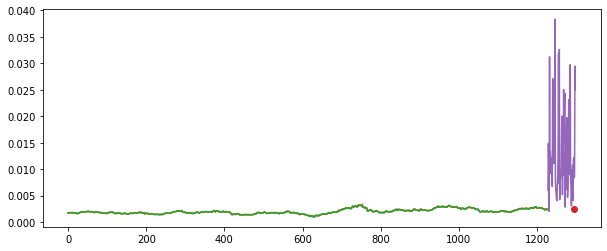

In [135]:
DS = 0
plt.figure(figsize=(10, 4))
plt.plot(X_Theta3[DS]) #, color="green"
plt.plot(X_Theta4[DS]) #, color="green"
plt.plot(X_Test[DS])
plt.plot(1294, Y_Test[DS],marker="o") #, color="red"
plt.plot(X_Axis_List[1228:1299],F_Theta3[DS]) #, color="blue"
#plt.plot(X_Axis_List[1228:1299],F_Theta4[DS])
plt.show()

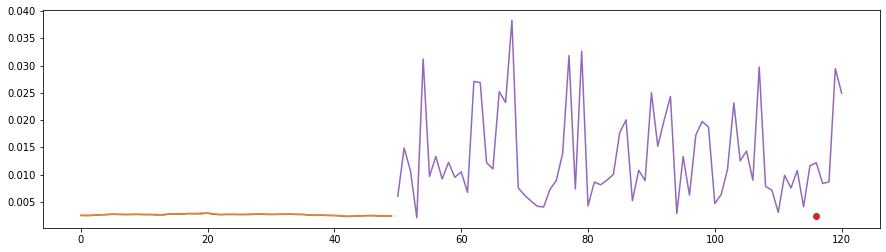

In [136]:
DS = 0
plt.figure(figsize=(15, 4))
plt.plot(X_Theta3[DS][-50:]) #, color="green"
plt.plot(X_Theta4[DS][-50:]) #, color="green"
plt.plot(X_Test[DS][-50])
plt.plot(116, Y_Test[DS],marker="o") #, color="red"
plt.plot(X_Axis_List[50:121],F_Theta3[DS]) #, color="blue"
#plt.plot(X_Axis_List[50:121],F_Theta4[DS])
plt.show()

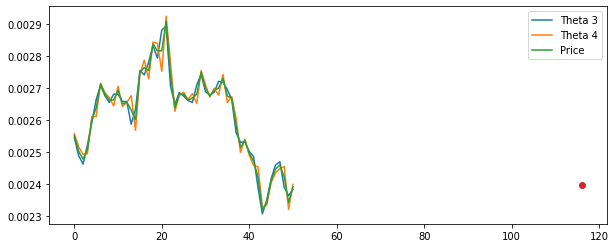

In [137]:
DS = 0
plt.figure(figsize=(10, 4))
plt.plot(X_Theta3[DS][-51:], label = "Theta 3") #, color="green"
plt.plot(X_Theta4[DS][-51:], label = "Theta 4") #, color="green"
plt.plot(X_Test[DS][-51:], label = "Price")
plt.plot(116, Y_Test[DS],marker="o") #, color="red"
plt.legend()
plt.show()

# Step 5. Convert forecast to price band

In [16]:
# Function to calculate 5% band i.e. 
#     0 to 5% = U1 (including 0), 5 to 10% = U2, 10 to 15% = U3, 15 to 20% = U4, >= U5.
#     <0 to -5% = D1, -5 to -10% = D2, -10 to -15% = D3, -15 to -20 = D4, <-20% = D5.
def calc_band(input_pct):
    if input_pct > 20: 
        band = 5
        prefix = 'U'
    elif input_pct < -20: 
        band = 5
        prefix = "D"
    elif input_pct >= 0:
        band = math.floor(input_pct / 5) + 1 # Floor(1/5) is 0 so to make it Band 1 we need to add 1
        prefix = "U"
    elif input_pct < 0:
        band = math.floor(input_pct / 5) # Floor(-1/5) is -1 so no need to add 1
        prefix = "D"
    else: # NaN for example
        band = 0
        prefix = "E" # Error band
    return prefix + str(abs(band))

In [17]:
# Calculate the 1 week average of the forecasted Theta prices
# Then calcualte the difference to the normalised X last price
# Then calculate the price band
F_Band_List = []
for i in range(len(F_Theta3)):
    # Calculate the 1 week average of the forecasted Theta prices
    Days = Y[i][5]
    # print(F_Theta3[i][:Days])
    F_Theta3_Avg = F_Theta3[i] #np.average(F_Theta3[i][-Days:])
    F_Theta4_Avg = F_Theta4[i] #np.average(F_Theta4[i][-Days:])

    # Average the two Thetas
    F_Avg = (F_Theta3_Avg + F_Theta4_Avg)/2

    # Calculate the difference to the normalised X last price
    X_Last_Price_Norm = Y[i][7]
    F_Diff = F_Avg - X_Last_Price_Norm

    # Calculate the price band
    F_Band = calc_band(F_Diff)
    F_Band_List.append(F_Band)    

# Step 6. Evaluate the result

In [18]:
# Compare the actual price band and the forecasted band from Theta lines
F_Status_List = []
Y_Band_List = []

for i in range(len(F_Band_List)):
    Y_Band = Y[i][8]
    Y_Band_List.append(Y_Band)
    
    F_Status = 1 if Y_Band == F_Band_List[i] else 0
    F_Status_List.append(F_Status)
    # print(Y_Band, F_Band_List[i], F_Status)
    
sum(F_Status_List)

97

In [19]:
matthews_corrcoef(Y_Band_List, F_Band_List) 

2.8216936320294016e-05

In [20]:
# Distribution of forecasted bands
counter=collections.Counter(F_Band_List)
pprint(dict(counter))

{'D1': 638, 'U1': 362}


# Step 7. Save output to CSV file

In [21]:
output_file   = ""
for i in range(len(Y_Band_List)):
    output = Y_Band_List[i] + "," +  Y_Band_List[i] + "," + str(F_Status_List[i]) + "\n"
    output_file = output_file + output   

In [22]:
# print(output_file)
File_Path = "/content/drive/My Drive/Colab Notebooks/3. Code/4. Combine/Output/"
f = open(File_Path + File_Name, "w")
f.write(output_file)
f.close()